We simulated data to find out how PAC arises with different parameters, and how the parameters affect each other.

    1) Simulate sinusoid
    2) 'Roll' sinusoid to not have same phase every time
    2) Add brown noise
    3) For each cycle, create distribution from which samples are taken to define HF activity
    4) For each HF activity (depending on LF, but 10000 in total signal) simulate a sinusoid and add to cycle of signal
    5) use FOOOF, ByCycle, and measure PAC


For each signal parameters are randomly chosen from these options:

    1) Frequency:           [5, 10, 20]             Hz  
    
Ideally, we would pick a random number between 4 and 24 Hz as LF, but not possible with current ByCycle yet

    2) Brown noise slope:   [-2 : -1]               Exp
    
We cannot to up to -3 exp for brown noise, because there not enough power in the PSD and will be highly effected by adding HF's 

    3) Firing distribution  [.01, .04, .16, .64]    The STD of distributioin 0-1 with mean .5
    4) HF activity          [80 : 250]              Hz
    


In [1]:
import os 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model


In [2]:
# Set directory in which the data structure can be found
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')

# data
simulation_features = pd.read_csv('simulation_features_2_0_0.csv', sep=',')

# Relationship between firing distributions, PAC, and shape (volt_amp & sym)

In [3]:
# create absolute values for symmetry measures
simulation_features['rdsym_abs'] = abs(simulation_features['rdsym'] - .5)
simulation_features['ptsym_abs'] = abs(simulation_features['ptsym'] - .5)

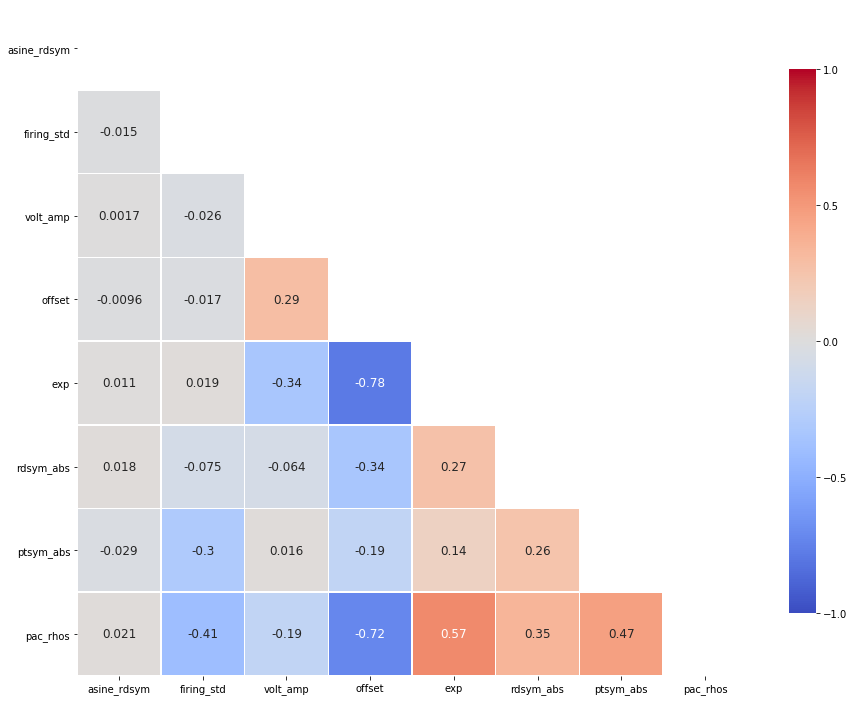

In [4]:
#### first create new dataframe with only the features we want to plot
corr_features_df = simulation_features[['asine_rdsym', 'firing_std', 'volt_amp',
       'offset', 'exp', 'rdsym_abs', 'ptsym_abs', 'pac_rhos']].copy()

corr_matrix = corr_features_df.corr()

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(15, 20))

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .5,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

 <div class="alert alert-success">
Awesome! We see correlations we expect. Such as higher variance in HF firing and lower PAC & lower amplitudes. While more assymetry and higher amplitudes give more PAC.
</div>

# Proof that firing rates are related to PAC and Shape

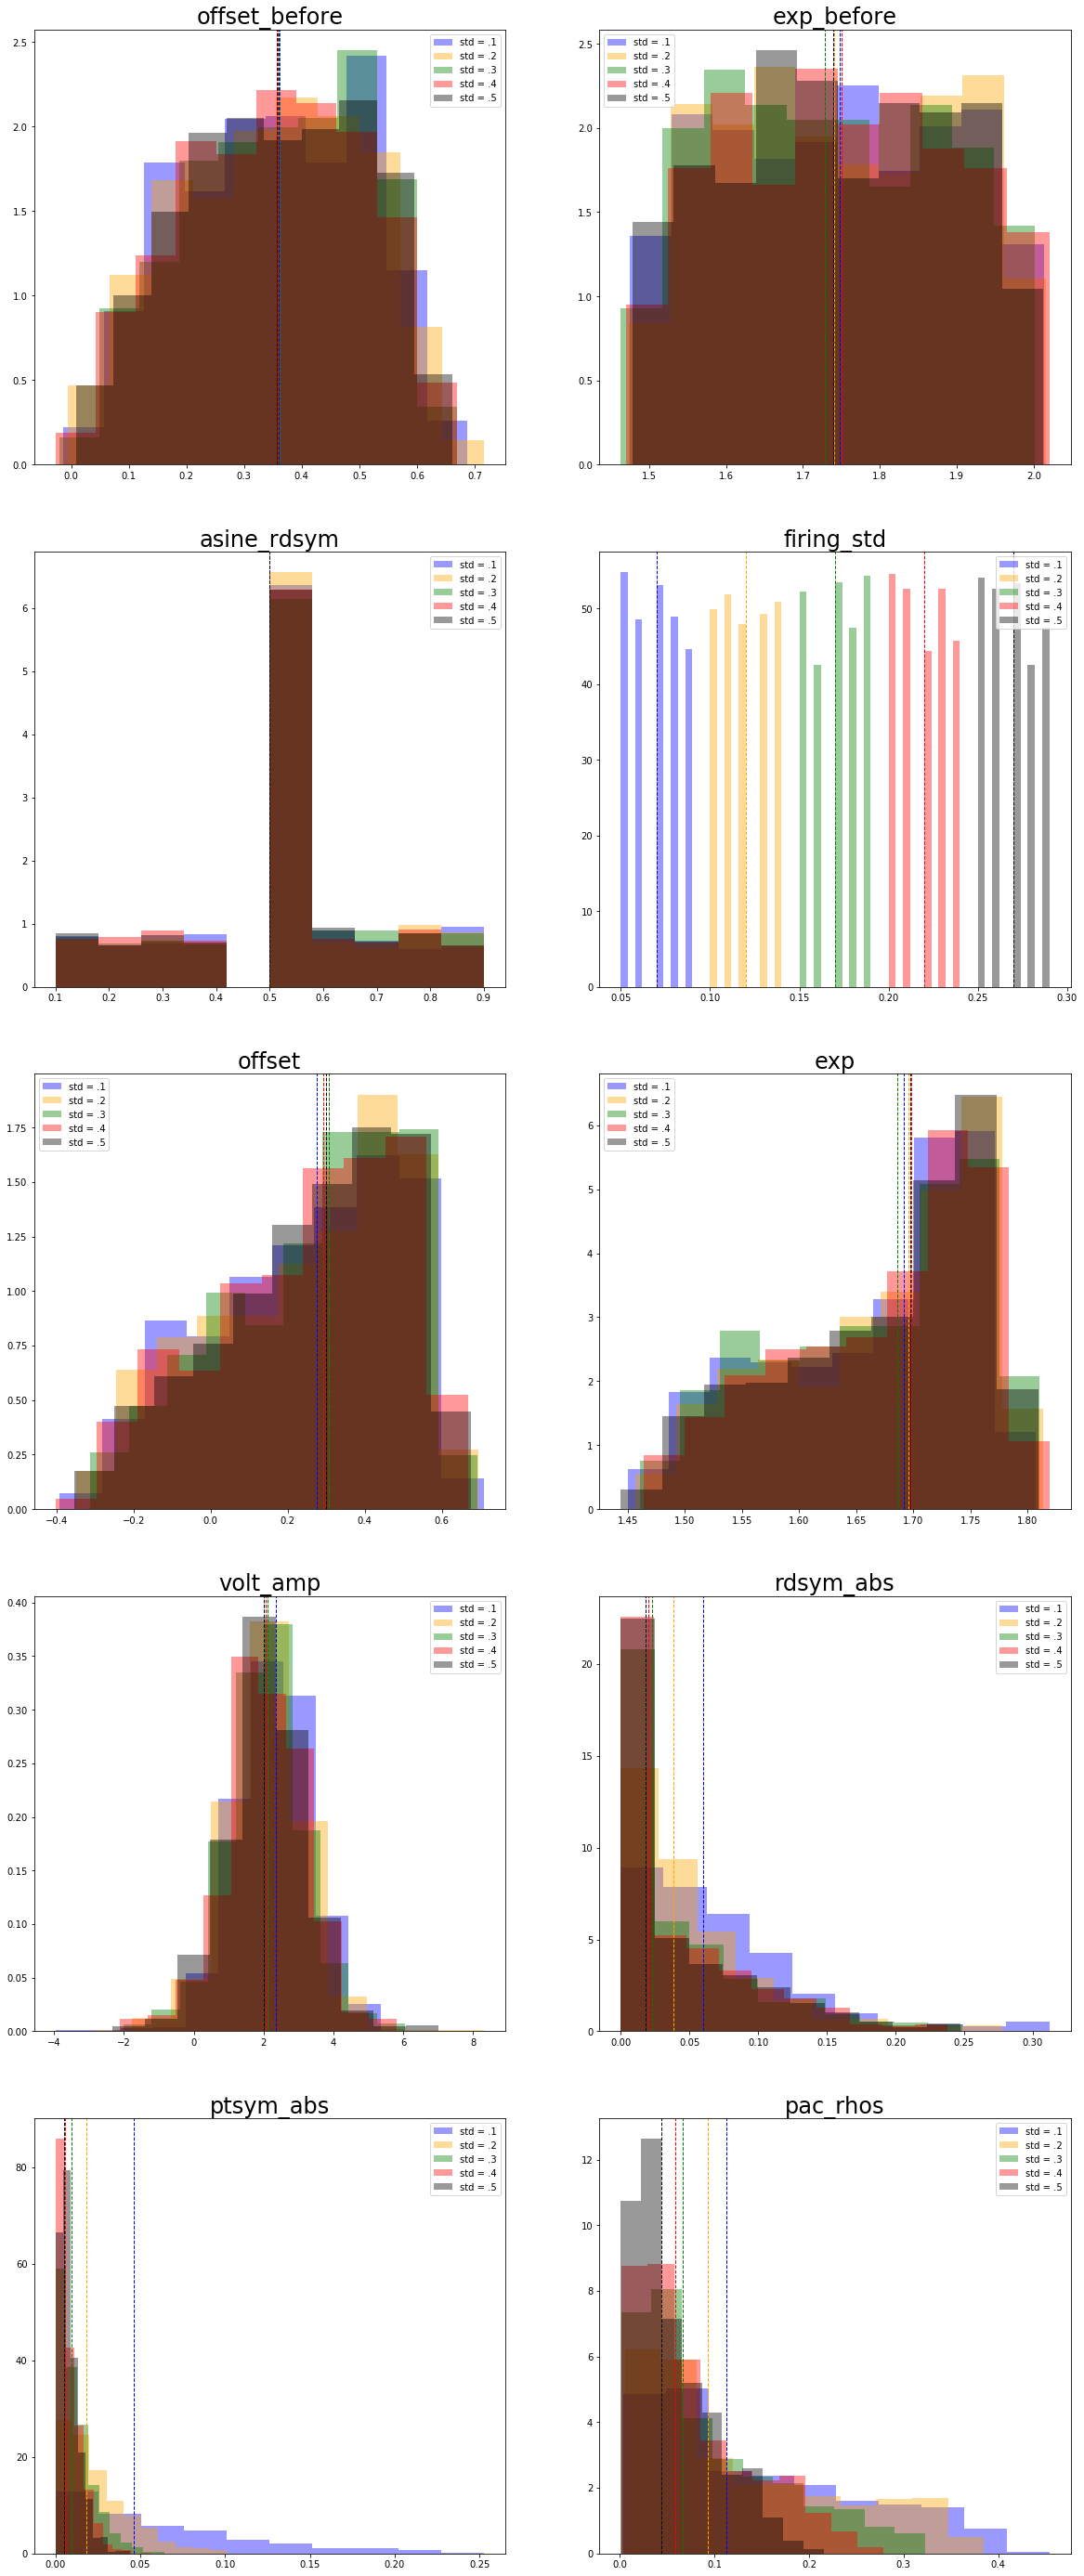

In [5]:
# for statistics
from scipy.stats import f_oneway

# manually set which columns you want to plot

hist_list = ['offset_before', 'exp_before', 'asine_rdsym', 'firing_std', 'offset', 'exp', 'volt_amp',
       'rdsym_abs', 'ptsym_abs', 'pac_rhos']

kwargs = dict(alpha=0.4, density=True, bins=10)

plt.figure(figsize=(20,50))
for ii in range(len(hist_list)):  
        
 
    # subplots 3x3
    plt.subplot(5,2,ii+1)
    #xticks([]), yticks([])
    
    plt.hist(simulation_features[(simulation_features['firing_std']>= .05) & (simulation_features['firing_std']<.1)][hist_list[ii]], 
             color='blue', label = 'std = .1', **kwargs)
    plt.hist(simulation_features[(simulation_features['firing_std']>= .1) & (simulation_features['firing_std']<.15)][hist_list[ii]], 
             color='orange', label = 'std = .2', **kwargs)
    plt.hist(simulation_features[(simulation_features['firing_std']>= .15) & (simulation_features['firing_std']<.2)][hist_list[ii]], 
             color='green', label = 'std = .3', **kwargs)
    plt.hist(simulation_features[(simulation_features['firing_std']>= .2) & (simulation_features['firing_std']<.25)][hist_list[ii]], 
             color='red', label = 'std = .4', **kwargs)
    plt.hist(simulation_features[(simulation_features['firing_std']>= .25) & (simulation_features['firing_std']<.3)][hist_list[ii]], 
             color='black', label = 'std = .5', **kwargs)
    
    plt.axvline(np.median(simulation_features[(simulation_features['firing_std']>= .05) & (simulation_features['firing_std']<.1)][hist_list[ii]]), 
                color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(simulation_features[(simulation_features['firing_std']>= .1) & (simulation_features['firing_std']<.15)][hist_list[ii]]), 
                color='orange', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(simulation_features[(simulation_features['firing_std']>= .15) & (simulation_features['firing_std']<.2)][hist_list[ii]]), 
                color='green', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(simulation_features[(simulation_features['firing_std']>= .2) & (simulation_features['firing_std']<.25)][hist_list[ii]]), 
                color='red', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(simulation_features[(simulation_features['firing_std']>= .25) & (simulation_features['firing_std']<.3)][hist_list[ii]]), 
                color='black', linestyle='dashed', linewidth=1)
    
    # print statistics
#    stats = f_oneway(features_df[features_df['Clusters']==0][features_df.columns[jj]],
 #           features_df[features_df['Clusters']==1][features_df.columns[jj]], 
  #          features_df[features_df['Clusters']==13][features_df.columns[jj]]) 
    
    # plt.title(features_df.columns[jj] + '  ' + 'pval = ' + str(stats[1]), size=16)
    plt.legend()
    plt.title(hist_list[ii], size=24)

 <div class="alert alert-success">
 Seem to be differences in PAC values, Amplitude and symmetry measures, but we need more simulations. Not really big differences in FOOOF measures, but have to tweak FOOOF parameters first to really conclude something.
</div>

# Predicting Rho value with feature for each firing variance group

In [6]:
simulation_features[(simulation_features['firing_std']> .1)]

,it,freq,asine_rdsym,noise_exp,firing_std,offset_before,exp_before,offset,exp,volt_amp,rdsym,ptsym,pac_rhos,pac_presence,rdsym_abs,ptsym_abs
0,0,10,0.1,-1.974014,1.00,0.060304,1.940930,-0.133194,1.770677,1.280514,0.274097,0.501908,0.109499,1,0.225903,0.001908
1,1,10,0.9,-1.890943,0.11,0.204607,1.870622,0.144607,1.797909,1.505330,0.609524,0.514563,0.234475,1,0.109524,0.014563
3,3,10,0.8,-1.922386,1.00,0.048492,1.883739,-0.168004,1.716838,4.858116,0.683300,0.510000,0.033521,1,0.183300,0.010000
4,4,10,0.5,-1.687587,1.00,0.356075,1.679547,0.309908,1.649532,1.523671,0.523877,0.504169,0.027337,1,0.023877,0.004169
5,5,10,0.8,-1.788005,0.28,0.327927,1.802033,0.205189,1.714127,2.445346,0.616414,0.505213,0.032415,1,0.116414,0.005213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,4596,10,0.2,-1.964124,0.14,0.101673,1.970757,-0.162703,1.754371,3.283627,0.295918,0.555051,0.310880,1,0.204082,0.055051
4597,4597,10,0.5,-1.658858,0.29,0.420265,1.651752,0.406006,1.637714,2.559087,0.491379,0.505747,0.043267,1,0.008621,0.005747
4598,4598,10,0.5,-1.938678,0.15,0.169355,1.926788,-0.060758,1.753977,3.134157,0.458716,0.492602,0.210380,1,0.041284,0.007398
4599,4599,10,0.2,-1.650387,0.26,0.502134,1.667554,0.478577,1.643212,2.592477,0.433628,0.506667,0.028408,1,0.066372,0.006667


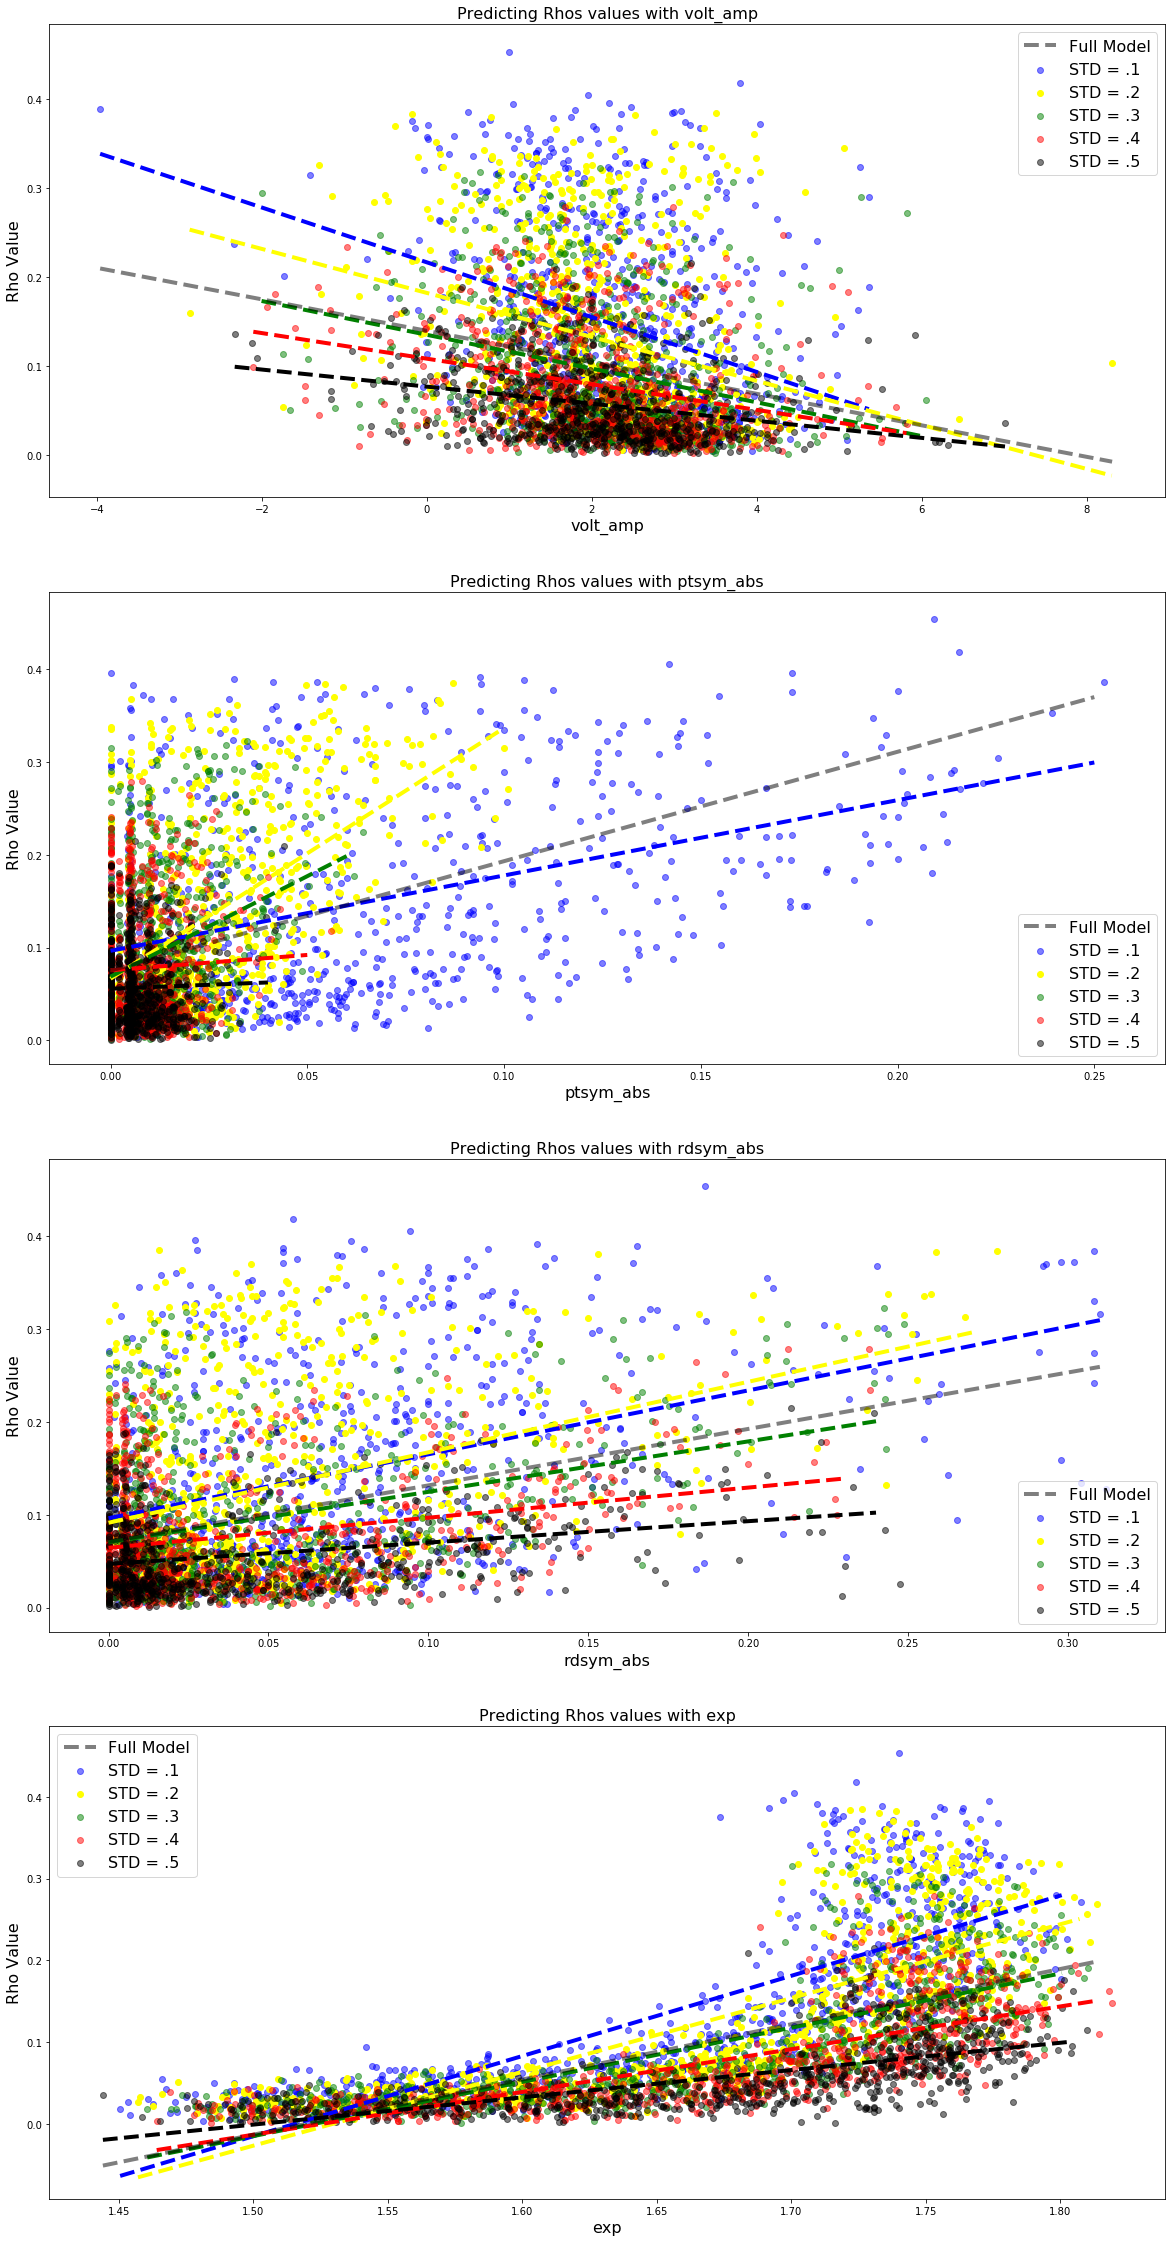

In [7]:
# get Rho values for each firing distribution
pac_rhos_std1 = simulation_features[(simulation_features['firing_std']>= .05) & (simulation_features['firing_std']<.1)]['pac_rhos'].values.reshape(-1,1)
pac_rhos_std2 = simulation_features[(simulation_features['firing_std']>= .1) & (simulation_features['firing_std']<.15)]['pac_rhos'].values.reshape(-1,1)
pac_rhos_std3 = simulation_features[(simulation_features['firing_std']>= .15) & (simulation_features['firing_std']<.2)]['pac_rhos'].values.reshape(-1,1)
pac_rhos_std4 = simulation_features[(simulation_features['firing_std']>= .2) & (simulation_features['firing_std']<.25)]['pac_rhos'].values.reshape(-1,1)
pac_rhos_std5 = simulation_features[(simulation_features['firing_std']>= .25) & (simulation_features['firing_std']<.3)]['pac_rhos'].values.reshape(-1,1)


feature = ['volt_amp', 'ptsym_abs', 'rdsym_abs', 'exp']


plt.figure(figsize=(20,40))
for ii in range(len(feature)):  
        
    # reshape other feature
    feature_std1 = simulation_features[(simulation_features['firing_std']>= .05) & (simulation_features['firing_std']<.1)][feature[ii]].values.reshape(-1,1)
    feature_std2 = simulation_features[(simulation_features['firing_std']>= .1) & (simulation_features['firing_std']<.15)][feature[ii]].values.reshape(-1,1)
    feature_std3 = simulation_features[(simulation_features['firing_std']>= .15) & (simulation_features['firing_std']<.2)][feature[ii]].values.reshape(-1,1)
    feature_std4 = simulation_features[(simulation_features['firing_std']>= .2) & (simulation_features['firing_std']<.25)][feature[ii]].values.reshape(-1,1)
    feature_std5 = simulation_features[(simulation_features['firing_std']>= .25) & (simulation_features['firing_std']<.3)][feature[ii]].values.reshape(-1,1)

    plt.subplot(4,1,ii+1)
    
    # STD .1
    plt.scatter(simulation_features[(simulation_features['firing_std']>= .05) & (simulation_features['firing_std']<.1)][feature[ii]],
                simulation_features[(simulation_features['firing_std']>= .05) & (simulation_features['firing_std']<.1)]['pac_rhos'],
               color='blue', alpha =.5, label='STD = .1')

    # STD .2
    plt.scatter(simulation_features[(simulation_features['firing_std']>= .1) & (simulation_features['firing_std']<.15)][feature[ii]],
                simulation_features[(simulation_features['firing_std']>= .1) & (simulation_features['firing_std']<.15)]['pac_rhos'],
               color='yellow', alpha =1, label='STD = .2')

    # STD .3
    plt.scatter(simulation_features[(simulation_features['firing_std']>= .15) & (simulation_features['firing_std']<.2)][feature[ii]],
                simulation_features[(simulation_features['firing_std']>= .15) & (simulation_features['firing_std']<.2)]['pac_rhos'],
               color='green', alpha =.5, label='STD = .3')

    # STD .4
    plt.scatter(simulation_features[(simulation_features['firing_std']>= .2) & (simulation_features['firing_std']<.25)][feature[ii]],
                simulation_features[(simulation_features['firing_std']>= .2) & (simulation_features['firing_std']<.25)]['pac_rhos'],
               color='red', alpha =.5, label='STD = .4')
    
    # STD .5
    plt.scatter(simulation_features[(simulation_features['firing_std']>= .25) & (simulation_features['firing_std']<.3)][feature[ii]],
                simulation_features[(simulation_features['firing_std']>= .25) & (simulation_features['firing_std']<.3)]['pac_rhos'],
               color='black', alpha =.5, label='STD = .5')

    # Reg STD .1
    reg1 = linear_model.LinearRegression()
    reg1.fit(feature_std1, pac_rhos_std1)
    xs = np.arange(min(feature_std1), max(feature_std1),0.01)
    ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='blue', linewidth=4, alpha=1)

    # Reg STD .2
    reg2= linear_model.LinearRegression()
    reg2.fit(feature_std2, pac_rhos_std2)
    xs = np.arange(min(feature_std2), max(feature_std2),0.01)
    ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='yellow', linewidth=4, alpha=1)

    # Reg STD .3
    reg3 = linear_model.LinearRegression()
    reg3.fit(feature_std3, pac_rhos_std3)
    xs = np.arange(min(feature_std3), max(feature_std3),0.01)
    ys = reg3.intercept_[0] + reg3.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='green', linewidth=4, alpha=1)

    # Reg STD .4
    reg4 = linear_model.LinearRegression()
    reg4.fit(feature_std4, pac_rhos_std4)
    xs = np.arange(min(feature_std4), max(feature_std4),0.01)
    ys = reg4.intercept_[0] + reg4.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='red', linewidth=4, alpha=1)

    # Reg STD .5
    reg5 = linear_model.LinearRegression()
    reg5.fit(feature_std5, pac_rhos_std5)
    xs = np.arange(min(feature_std5), max(feature_std5),0.01)
    ys = reg5.intercept_[0] + reg5.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='black', linewidth=4, alpha=1)

    # Regression model on all combined
    # concatenate the three groups and reshape
    pac_rhos_comb = np.reshape(np.concatenate((pac_rhos_std1, pac_rhos_std2, pac_rhos_std3, pac_rhos_std4, pac_rhos_std5),
                                              axis=None), [-1, 1])
    feature_comb = np.reshape(np.concatenate((feature_std1, feature_std2, feature_std3, feature_std4, feature_std5), 
                                              axis=None), [-1, 1])

    # regression combo
    reg6= linear_model.LinearRegression()
    reg6.fit(feature_comb, pac_rhos_comb)
    xs = np.arange(min(feature_comb), max(feature_comb),0.01)
    ys = reg6.intercept_[0] + reg6.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='black', linewidth=4, label='Full Model', alpha=.5)
    
    
    plt.title('Predicting Rhos values with ' + feature[ii], fontsize=16)
    plt.xlabel(feature[ii], fontsize=16)
    plt.ylabel('Rho Value', fontsize=16)
    plt.legend(fontsize=16)


 <div class="alert alert-success">
Very weird negative regressions between Rho value and Voltage Amplitude within a firing variance groups... 
</div>

 <div class="alert alert-success">
DIE LAASTSTE OVER EXP IS WEL INTERESSANT, WANT DE EXP'S ZIJN VRIJWEL GELIJK, MAAR IN EEN LAGE DISTRIBUTIE MET EEN HOGE EXP KOMEN DUS GROTERE RHO VALUES, EN DAT BOUWT LANGZAAM OP PER STD!
</div>

In [8]:
len(simulation_features[simulation_features['pac_presence']=='1'][simulation_features['firing_std'] == 0.01]) / \
len(simulation_features[simulation_features['firing_std'] == 0.01])

C:\Users\jaapv\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


ZeroDivisionError: division by zero

In [9]:


hi = [len(simulation_features[simulation_features['pac_presence']=='1'][simulation_features['firing_std'] == (test / 100)]) / \
len(simulation_features[simulation_features['firing_std'] == (test / 100)]) for test in range(5,30)]


C:\Users\jaapv\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


C:\Users\jaapv\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


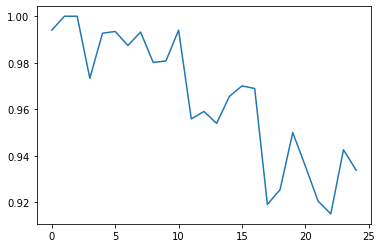

In [10]:

check = [len(simulation_features[simulation_features['pac_presence']=='1'][simulation_features['firing_std'] == (test / 100)]) / \
len(simulation_features[simulation_features['firing_std'] == (test / 100)]) for test in range(5,30)] 

plt.plot(check)

In [11]:
test = 7
len(simulation_features[simulation_features['pac_presence']=='1'][simulation_features['firing_std'] == (test / 100)])

C:\Users\jaapv\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


163

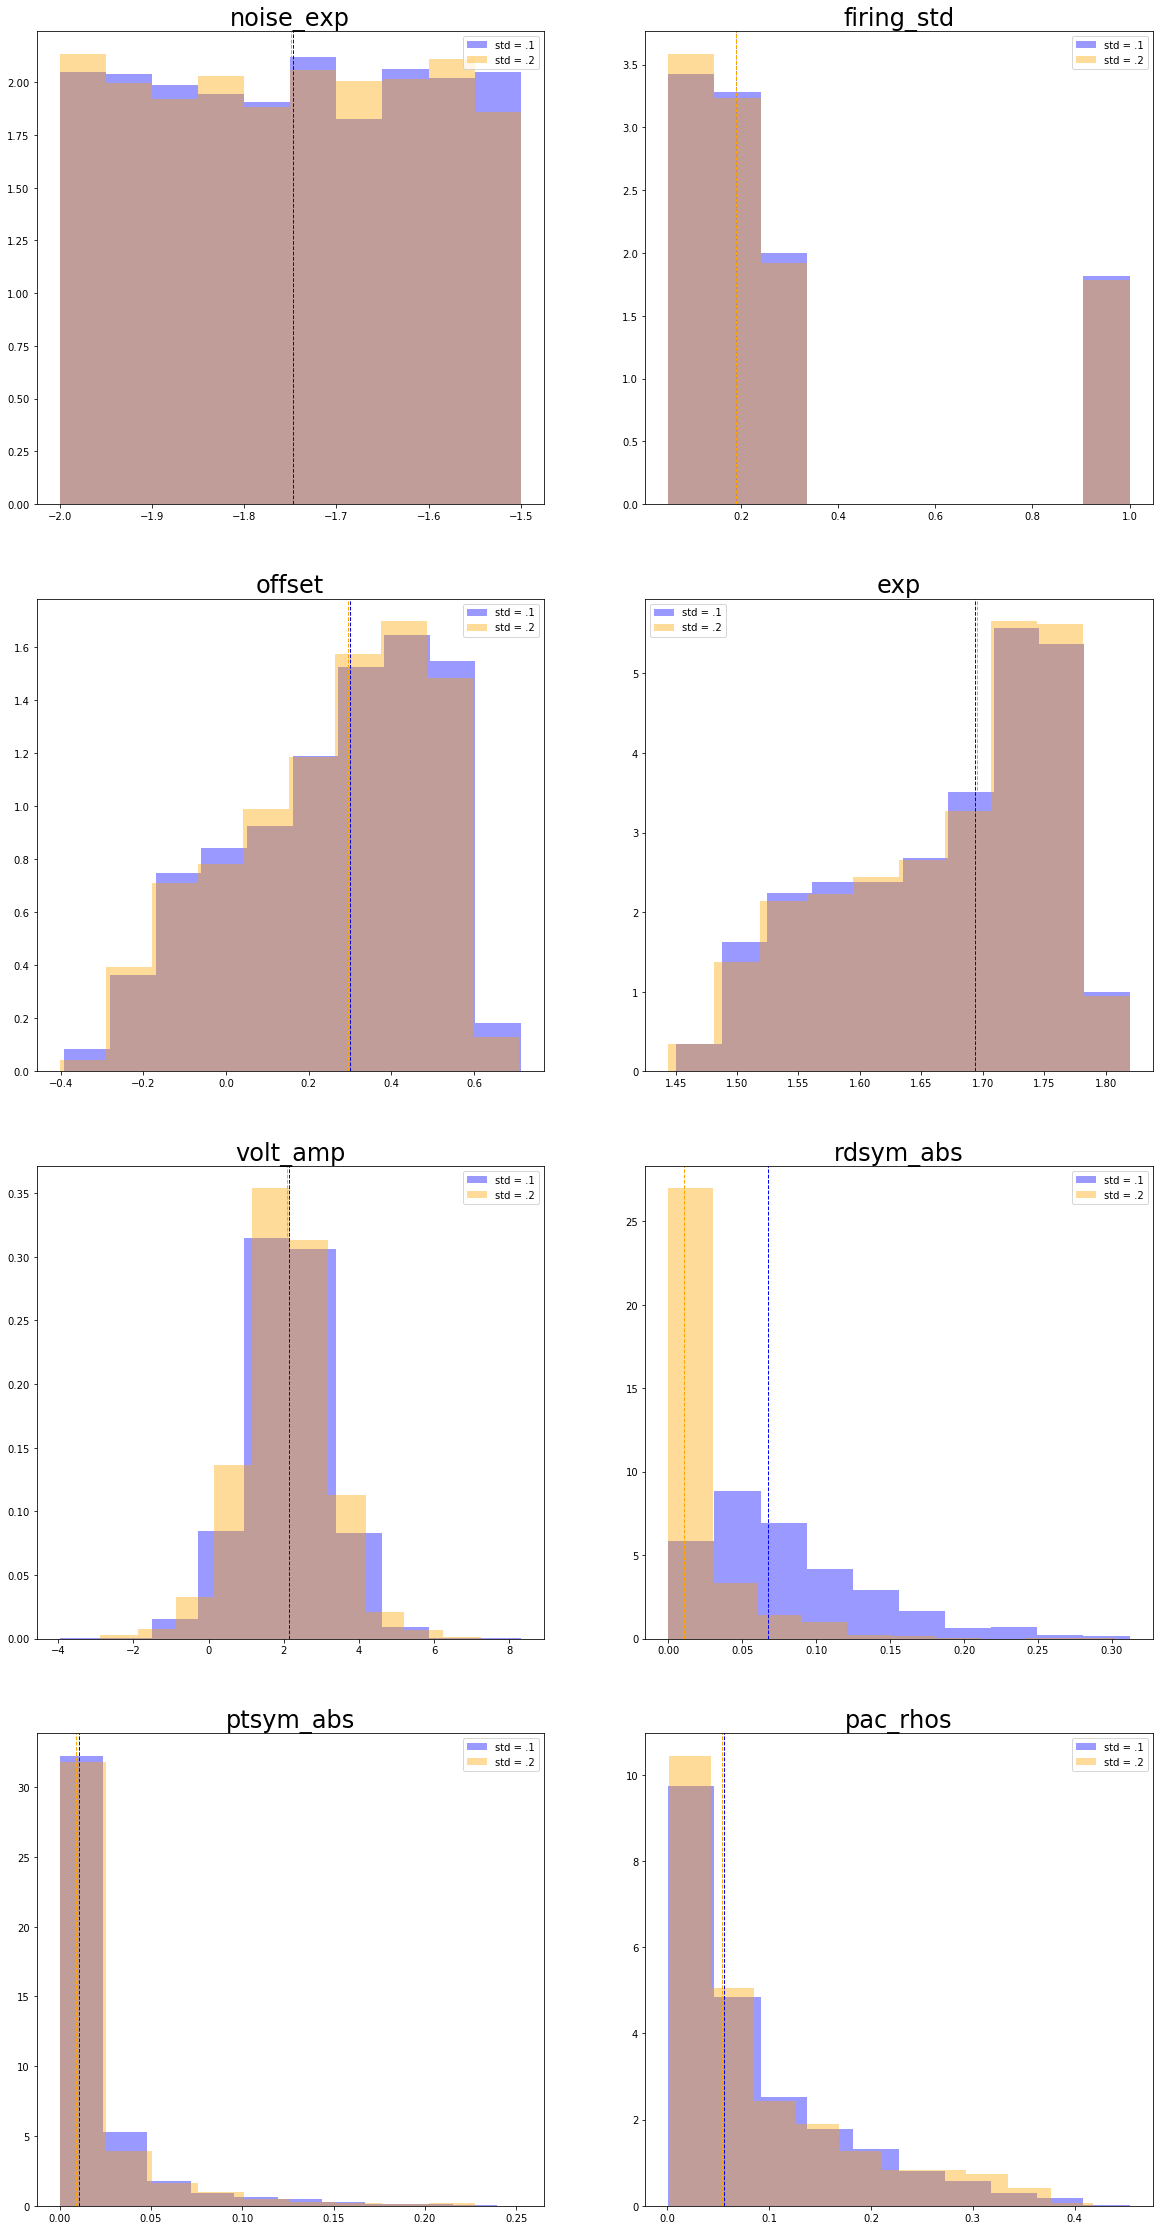

In [12]:
# for statistics
from scipy.stats import f_oneway


simulation_features = simulation_features.dropna()

# manually set which columns you want to plot
hist_list = ['noise_exp', 'firing_std', 'offset', 'exp', 'volt_amp',
       'rdsym_abs', 'ptsym_abs', 'pac_rhos']

kwargs = dict(alpha=0.4, density=True)#, bins=10)

plt.figure(figsize=(20,40))
for ii in range(len(hist_list)):  
        
 
    # subplots 3x3
    plt.subplot(4,2,ii+1)
    #xticks([]), yticks([])
    
    plt.hist(simulation_features[(simulation_features['asine_rdsym']!=.5)][hist_list[ii]], 
             color='blue', label = 'std = .1', **kwargs)
    plt.hist(simulation_features[(simulation_features['asine_rdsym']==.5)][hist_list[ii]], 
             color='orange', label = 'std = .2', **kwargs)

    
    plt.axvline(np.median(simulation_features[(simulation_features['asine_rdsym']!=.5)][hist_list[ii]]), 
                color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(simulation_features[(simulation_features['asine_rdsym']==.5)][hist_list[ii]]), 
                color='orange', linestyle='dashed', linewidth=1)

    
    # print statistics
#    stats = f_oneway(features_df[features_df['Clusters']==0][features_df.columns[jj]],
 #           features_df[features_df['Clusters']==1][features_df.columns[jj]], 
  #          features_df[features_df['Clusters']==13][features_df.columns[jj]]) 
    
    # plt.title(features_df.columns[jj] + '  ' + 'pval = ' + str(stats[1]), size=16)
    plt.legend()
    plt.title(hist_list[ii], size=24)